In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [2]:
import numpy as np
from scipy.signal import find_peaks
from tqdm import tqdm
from obspy import read, UTCDateTime, read_inventory
from obspy.signal import konnoohmachismoothing
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings("ignore")

# Functions

In [3]:
def calc_fft(data,npts,sr):
	Fdat = np.fft.rfft(data)
	freq = np.fft.rfftfreq(npts, d=1./sr)
	return 2.0/sr * np.abs(Fdat), freq

def select_station(st,station):
    return st.select(station=station).sort()

def get_median(i_mat):
    return np.nanmedian(i_mat,axis=0)

def smooth(i_fft,bandwidth=160,count=1):
    return konnoohmachismoothing.konno_ohmachi_smoothing(i_fft,freqs, bandwidth=bandwidth, count=count)

def peaks(i_fft,freqs,ax,distance=10):
    peaks, _ = find_peaks(i_fft, distance=distance)
    for peak in peaks:
        if freqs[peak] >= 0.3 and freqs[peak] <= 3:
            ax.text(freqs[peak], i_fft[peak],s=round(freqs[peak],2),size=8)
    return ax
def add_legend(ax,colors):
    custom_lines = [Line2D([0], [0], color=colors['E'], lw=5),
					Line2D([0], [0], color=colors['N'], lw=5),
					Line2D([0], [0], color=colors['Z'], lw=5)]
    pos = ax.get_position()
    ax.legend(custom_lines, ['EW', 'NS', 'Vertical'],loc='upper left',ncol=3,fontsize=12)
    return ax

# Building Information

![Bologna Building](Building.png)

In [4]:
stations = ['RE008', 'RE001', 'RE003', 'RE004', 'RE005', 'RE006']#['RE'+str(sta).zfill(3) for sta in range(1,7)]
borehole = ['RERI']

In [5]:
results = {key: {'Z':[],'N':[],'E':[]} for key in stations}

### Read StationXML

In [6]:
inv_re = read_inventory('Data/StationXML/LK.RE.xml',format='stationXML')
inv_reri = read_inventory('Data/StationXML/OX.RERI.xml',format='stationXML')

# Read Waveform

In [7]:
st_all = read('Data/Earthquake/*',format='MSEED')
st_all.sort();

## Remove Response

In [8]:
st_all.attach_response(inv_re)
st_all.attach_response(inv_reri)
st_all.remove_response(output='VEL');
st_all.detrend()
st_all.taper(max_percentage=0.05)
st_all.filter('bandpass',freqmin=0.2,freqmax=15)

 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

30 Trace(s) in Stream:

LK.RE001..EHE | 2023-10-25T13:45:25.944000Z - 2023-10-25T13:47:15.944000Z | 250.0 Hz, 27501 samples
...
(28 other traces)
...
OX.RERI.01.EHZ | 2023-10-25T13:45:25.944000Z - 2023-10-25T13:47:15.944000Z | 250.0 Hz, 27501 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

### Get Maximum Amplitude

In [9]:
pgv = 0
for tr in st_all:
    if max(abs(tr.data)) > pgv:
        pgv = max(abs(tr.data))

In [10]:
st = st_all.select(station='RE00*')
st_reri = st_all.select(station='RERI')

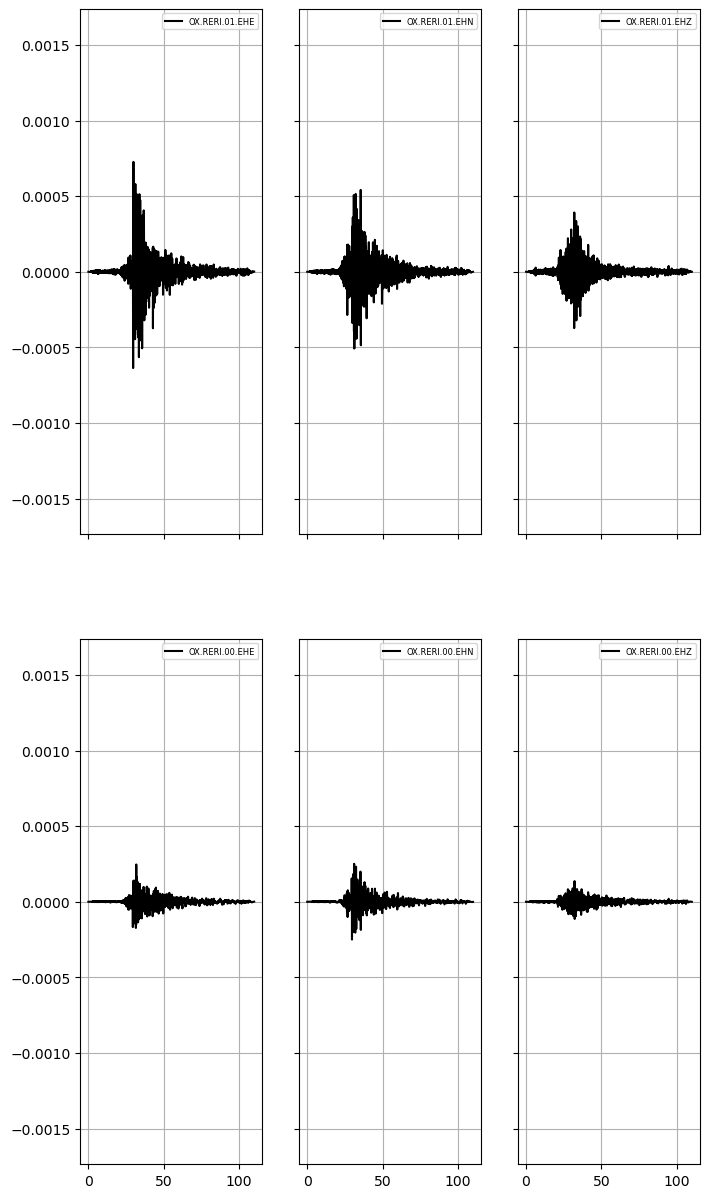

In [11]:
fig, axs = plt.subplots(nrows=2,ncols=3,dpi=100,figsize=(800/100,len(st_reri)*250/100),sharey=True,sharex=True)
axs[0,0].set_ylim(-1.1*pgv,1.1*pgv)
for i, loc in enumerate(['01','00']):
    st_reri_loc = st_reri.select(location=loc)
    for j, tr in enumerate(st_reri_loc):
        axs[i,j].plot(tr.times(),tr.data,c='k',label=tr.id)
        axs[i,j].grid('on','both')
        axs[i,j].legend(prop={'size': 6})

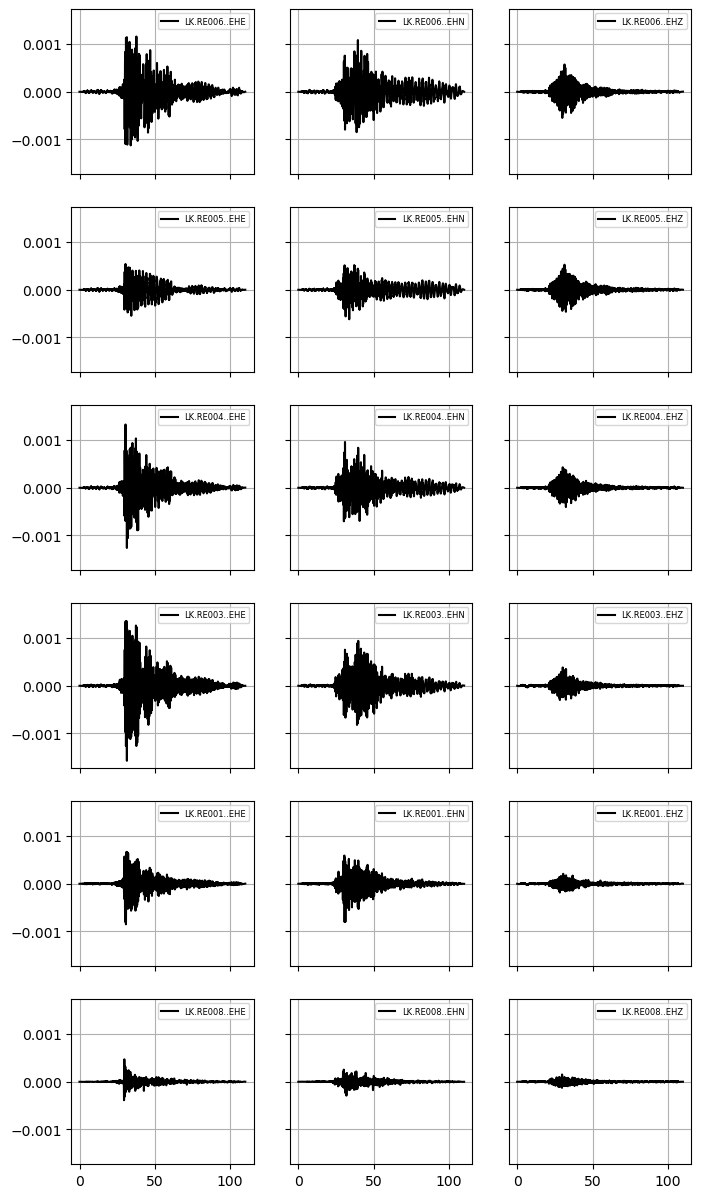

In [12]:
fig, axs = plt.subplots(nrows=len(stations),ncols=3,dpi=100,figsize=(800/100,len(stations)*250/100),sharey=True,sharex=True)
axs[0,0].set_ylim(-1.1*pgv,1.1*pgv)
for i, station in enumerate(stations[::-1]):
    st_sta = st.select(station=station)
    for j, tr in enumerate(st_sta):
        axs[i,j].plot(tr.times(),tr.data,c='k',label=tr.id)
        axs[i,j].grid('on','both')
        axs[i,j].legend(prop={'size': 6})

# FFT Calculation

In [13]:
for station in tqdm(stations):
    st_sta = select_station(st,station)
    for k, tr in enumerate(st_sta):
        amps, freqs = calc_fft(tr.data,tr.stats.npts,tr.stats.sampling_rate)
        results[station][tr.stats.channel[-1]] = np.array(amps)

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 385.00it/s]


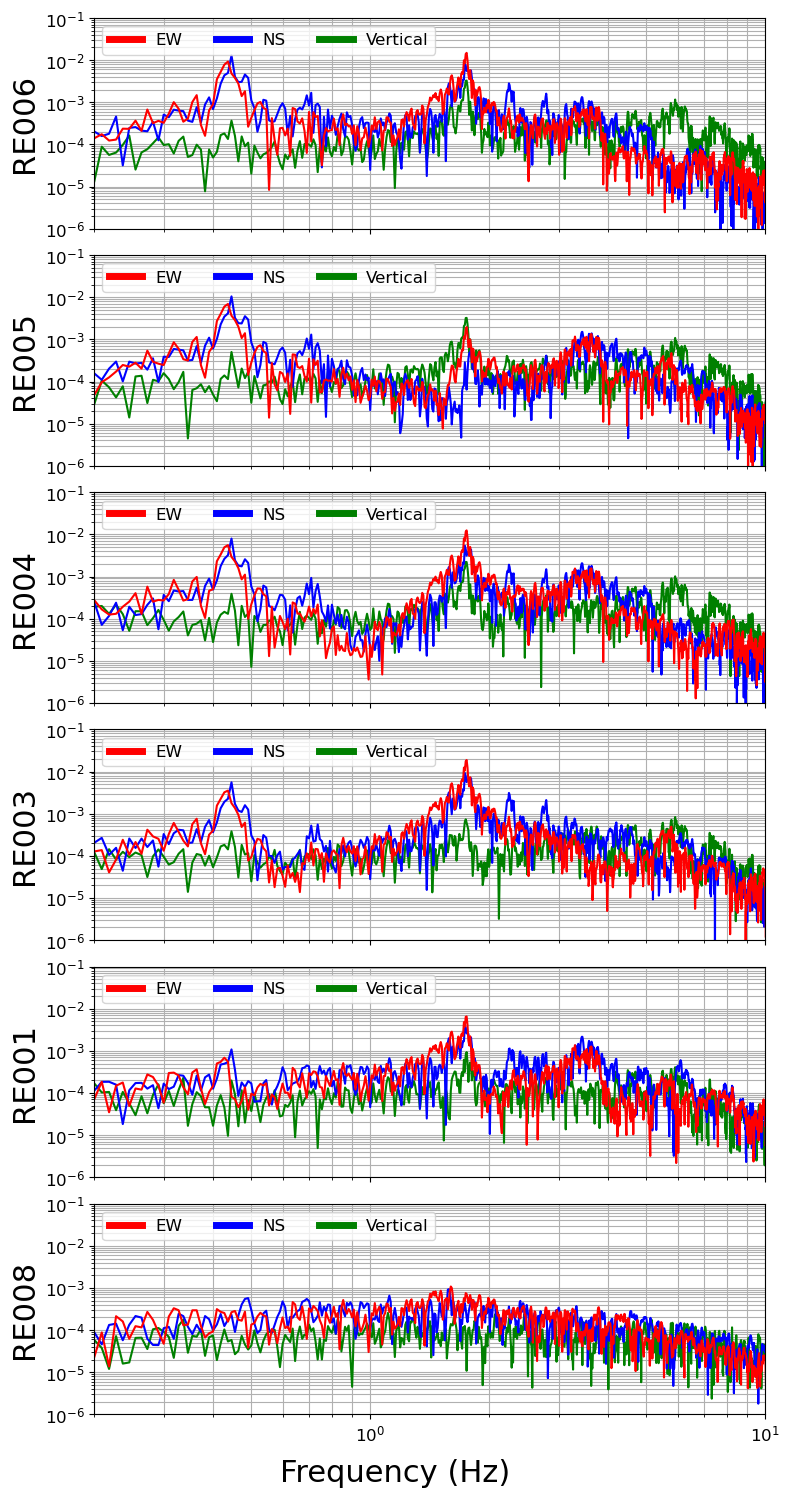

In [14]:
fig, axs = plt.subplots(nrows=len(stations),ncols=1,dpi=100,figsize=(800/100,len(stations)*250/100),sharey=True,sharex=True)
axs[0].set_xlim([0.2,10])
axs[0].set_ylim([10**-6,10**-1])
colors = {'E':'red','N':'blue','Z':'green'}
for i, station in enumerate(stations[::-1]):
    for channel in results[station].keys():
        values = results[station][channel]
        axs[i].loglog(freqs,values,c=colors[channel])
        axs[i].set_ylabel(station, fontsize=22)
        axs[i].grid('on','both')
        axs[i].tick_params(axis='both', which='both', labelsize=12)
    axs[i] = add_legend(axs[i],colors)
fig.supxlabel('Frequency (Hz)', fontsize=22)
plt.tight_layout()
plt.savefig('Figures/earthquake.png')

In [15]:
plt.close(fig)

# Spectral Ratio

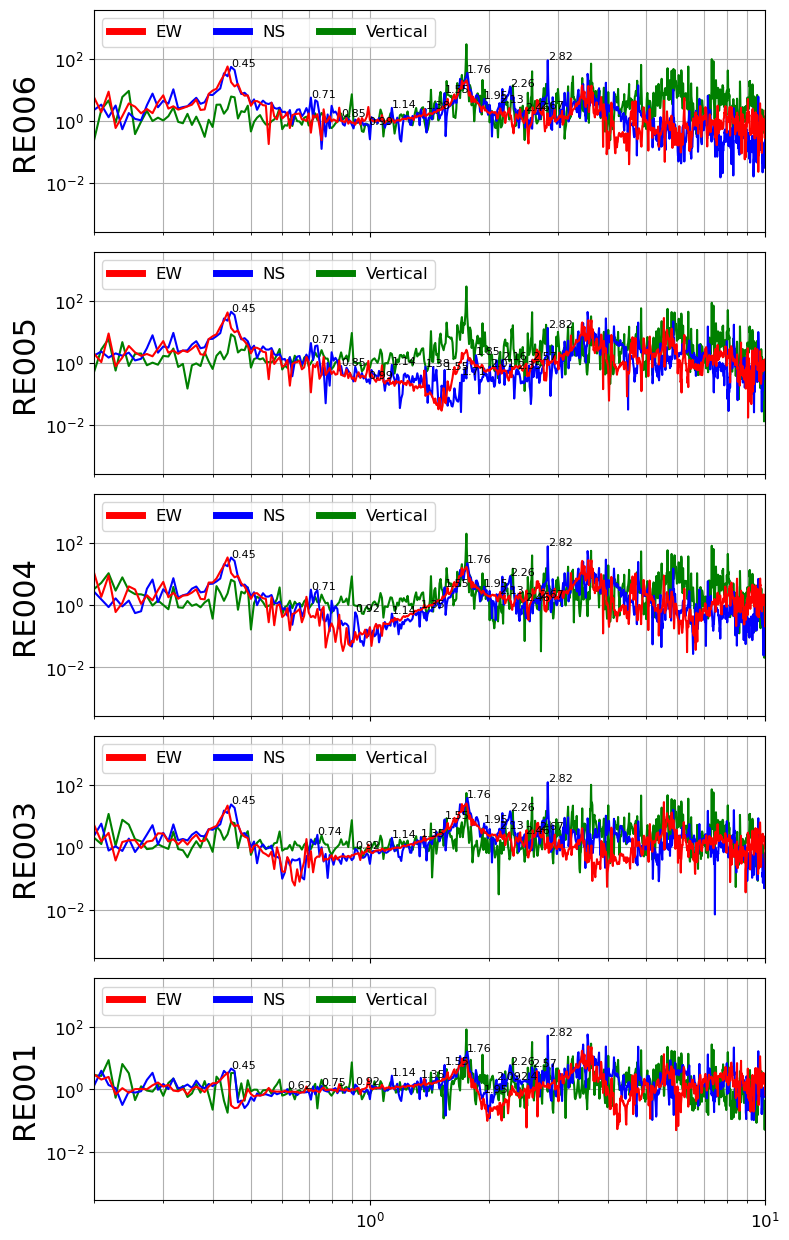

In [16]:
fig2, axs = plt.subplots(nrows=len(stations[1:]),ncols=1,dpi=100,figsize=(800/100,len(stations[1:])*(250/100)),sharey=True,sharex=True)
axs[0].set_xlim([0.2,10])
# axs[0].set_ylim([10**1,10**4])
colors = {'E':'red','N':'blue','Z':'green'}
ref = stations[0]
for i, station in enumerate(stations[1:][::-1]):
    for channel in results[station].keys():
        ref_values = results[ref][channel]
        values = results[station][channel]
        ratio = values/ref_values
        axs[i].loglog(freqs,ratio,c=colors[channel])
        axs[i].set_ylabel(station, fontsize=22)
        axs[i].grid('on','both')
        axs[i].tick_params(axis='both', which='both', labelsize=12)
        # Add Peak Values
        if channel == 'N':
            axs[i] = peaks(ratio,freqs,axs[i],distance=15)
    axs[i] = add_legend(axs[i],colors)
fig.supxlabel('Frequency (Hz)', fontsize=22)
plt.tight_layout()
plt.savefig('Figures/earthquake_spectral_ratio.png')

In [17]:
plt.close(fig2)